# Train Golf card game RL agent with DQN

imports

In [1]:
import time
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.utils import get_device
import matplotlib.pyplot as plt


In [2]:
from src.player.golf_train_env import GolfTrainEnv

In [3]:
# Initialize Gymnasium environment

env = GolfTrainEnv()

PPO is assumably faster with CPU than GPU.

200 000 steps took 4 mins
10 000 000 took 323 mins = 5,4 hours
100M steps took 5 days to reach 64M steps and then I had to stop it :(

In [4]:
EPISODES = 30000000

add a logger to inspect the training process

In [5]:

# Check frequency (episodes)
CHECK_FREQ = EPISODES / 100

class RewardLoggerCallback(BaseCallback):
    def __init__(self, check_freq: int = 1000, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.rewards = []
        self.timesteps = []
        self.episode_rewards = 0  # To track cumulative reward for each episode

    def _on_step(self) -> bool:
        # Update episode reward with current reward
        reward = self.locals["rewards"]  # Current reward from the environment
        self.episode_rewards += reward

        # Check if the episode is done
        if self.locals["dones"]:
            self.rewards.append(self.episode_rewards)
            self.timesteps.append(self.num_timesteps)
            if self.verbose > 0:
                print(f"Timestep {self.num_timesteps}: Episode reward = {self.episode_rewards}")
            self.episode_rewards = 0  # Reset for the next episode

        # Log at the specified frequency
        if self.num_timesteps % self.check_freq == 0:
            print(f"Timestep {self.num_timesteps}: Logging in progress...")

        return True
    
reward_logger = RewardLoggerCallback(check_freq=CHECK_FREQ)

optional: load a model trained earlier

In [6]:
# model_path = "golf_agent_1000000ep_DQN"
# model = DQN.load(model_path, env=env, device="auto") 

In [7]:
# Add a larger neural network as the games take quite long (>20 steps)
policy_kwargs = dict(net_arch=[256, 128])  

In [8]:
# To use CUDA you have to have a capable GPU and pytorch installment

model = PPO(
            "MlpPolicy",
            env,
            verbose=0,
            learning_rate=3e-4,  # tweak as needed
            policy_kwargs=policy_kwargs,
            device="cpu"
        )

print("Using device:", get_device()) 

Using device: cuda


actual training

In [9]:
start = time.time()

model.learn(EPISODES, callback=reward_logger)

print(f"Complete in {(time.time()-start)/60:.2f} minutes.")

[DEBUG] table card values:  [11, 0, 9]
[DEBUG] played card value:  5
[DEBUG] Did lottery: deck_inc: 1 played_inc: 49 total: 50 res: False
Complete at  18  turns.
REWARD: 4!
[DEBUG] table card values:  [3, 6, 9]
[DEBUG] played card value:  5
[DEBUG] Did lottery: deck_inc: 1 played_inc: 25 total: 26 res: False
Timestep 18: Episode reward = [3.1]
Complete at  17  turns.
REWARD: 30!
[DEBUG] table card values:  [0, 3, 12]
[DEBUG] played card value:  7
[DEBUG] Did lottery: deck_inc: 1 played_inc: 36 total: 37 res: False
Timestep 35: Episode reward = [25.9]
Complete at  32  turns.
REWARD: 17!
[DEBUG] table card values:  [11, 3, 9]
[DEBUG] played card value:  9
[DEBUG] Did lottery: deck_inc: 1 played_inc: 9 total: 10 res: False
Timestep 67: Episode reward = [15.400001]
Complete at  22  turns.
REWARD: 15!
[DEBUG] table card values:  [10, 7, 6]
[DEBUG] played card value:  12
[DEBUG] Did lottery: deck_inc: 81 played_inc: 1 total: 82 res: True
Timestep 89: Episode reward = [13.7]
Complete at  9  t

KeyboardInterrupt: 

optional: save model

In [12]:
model.save(f"golf_agent_onephase_{EPISODES}ep_DQN.zip")

plot the training process

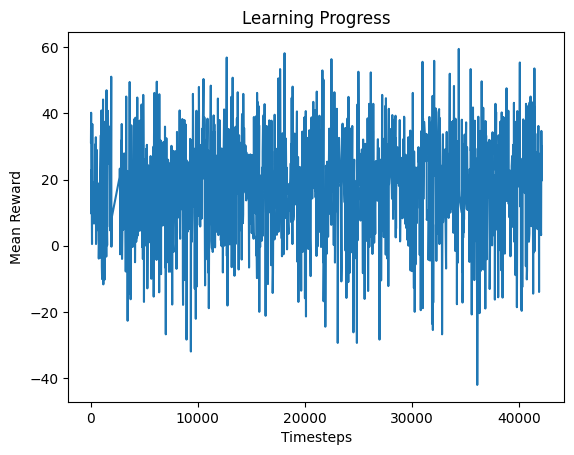

In [14]:
plt.plot(reward_logger.timesteps, reward_logger.rewards)
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Learning Progress")
plt.show()